In [22]:
import pandas as pd
try:
    # Read the CSV file while handling potential parsing errors
    df_X_train = pd.read_csv('X_train.csv')
    
    # Display the first few rows to verify
    print("DataFrame successfully created:")
    print(df_X_train.head())

except Exception as e:
    print(f"An error occurred: {e}")


DataFrame successfully created:
   source  host_response_time  host_is_superhost  host_listings_count  \
0       0                   2                  0                  1.0   
1       0                   2                  0                  2.0   
2       1                   1                  0                  5.0   
3       1                   2                  0                  1.0   
4       0                   2                  0                  2.0   

   host_verifications  host_identity_verified  neighbourhood_cleansed  \
0                   0                       1                      10   
1                   0                       0                      19   
2                   2                       1                      19   
3                   2                       1                      14   
4                   0                       0                      19   

   latitude  longitude  property_type  ...  review_scores_value  \
0  43.64590  -79.42423 

### Visualizing Target Predictability 

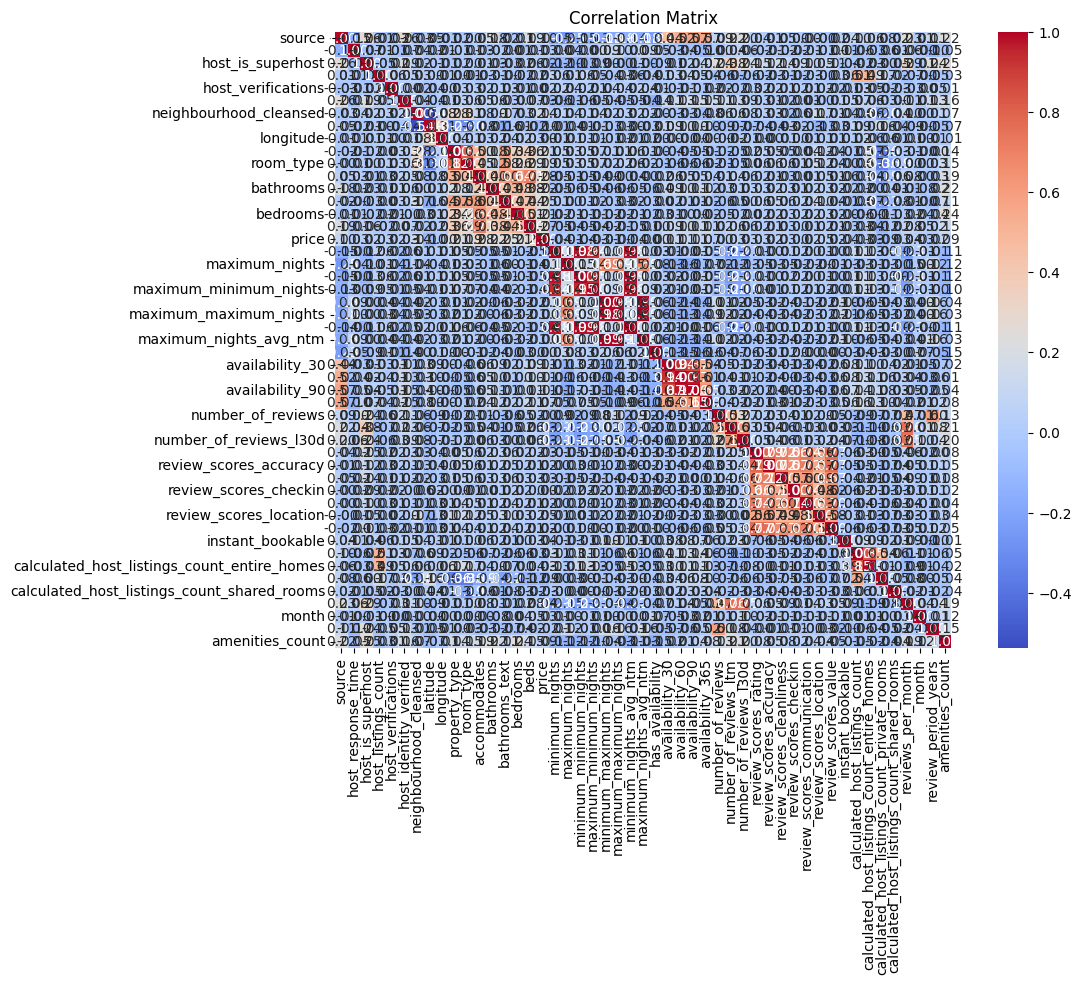

In [56]:
# a. Correlation Matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

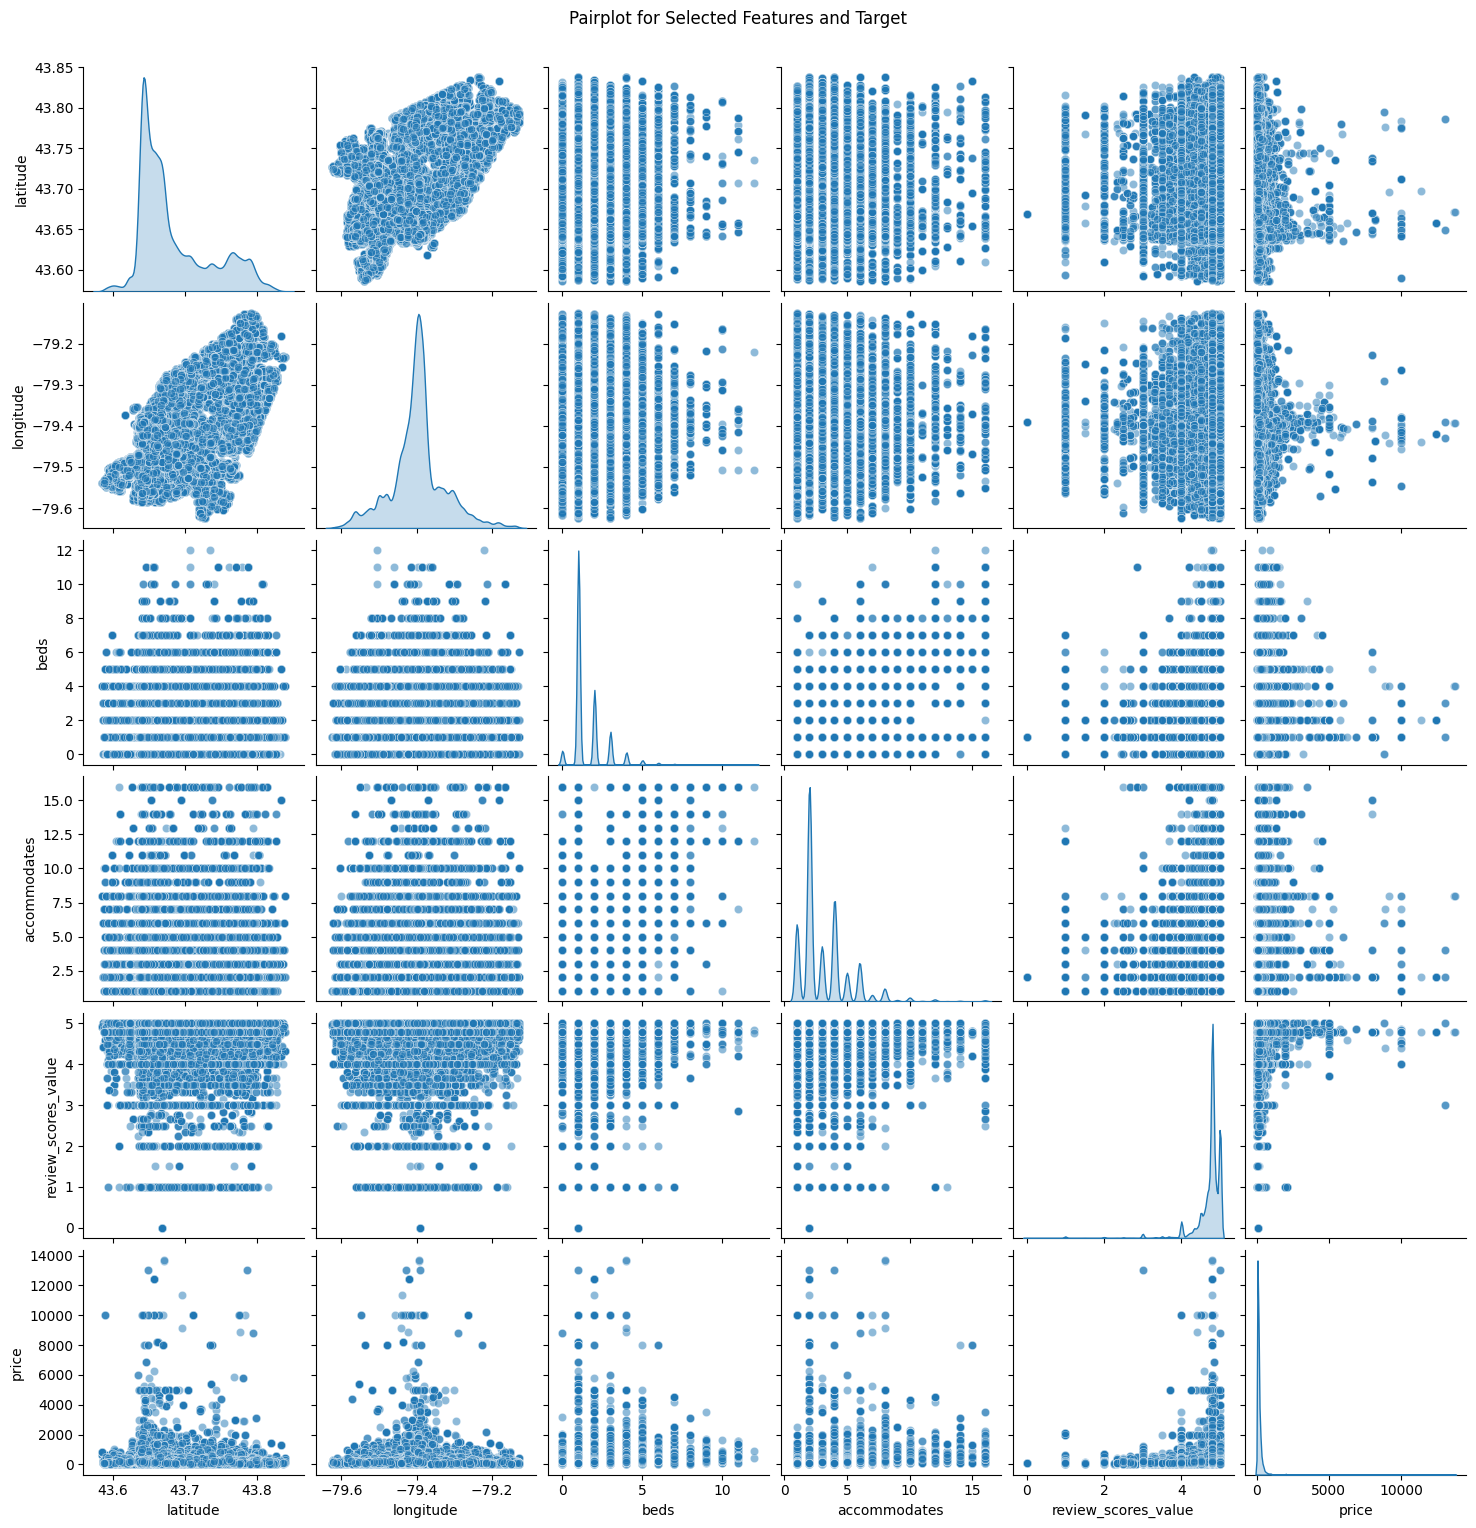

In [36]:
import seaborn as sns

# Select key features to visualize
selected_features = ['latitude', 'longitude', 'beds', 'accommodates', 'review_scores_value']

# Create pairplot for selected features
sns.pairplot(df_X_train[selected_features + ['price']], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle("Pairplot for Selected Features and Target", y=1.02)
plt.show()


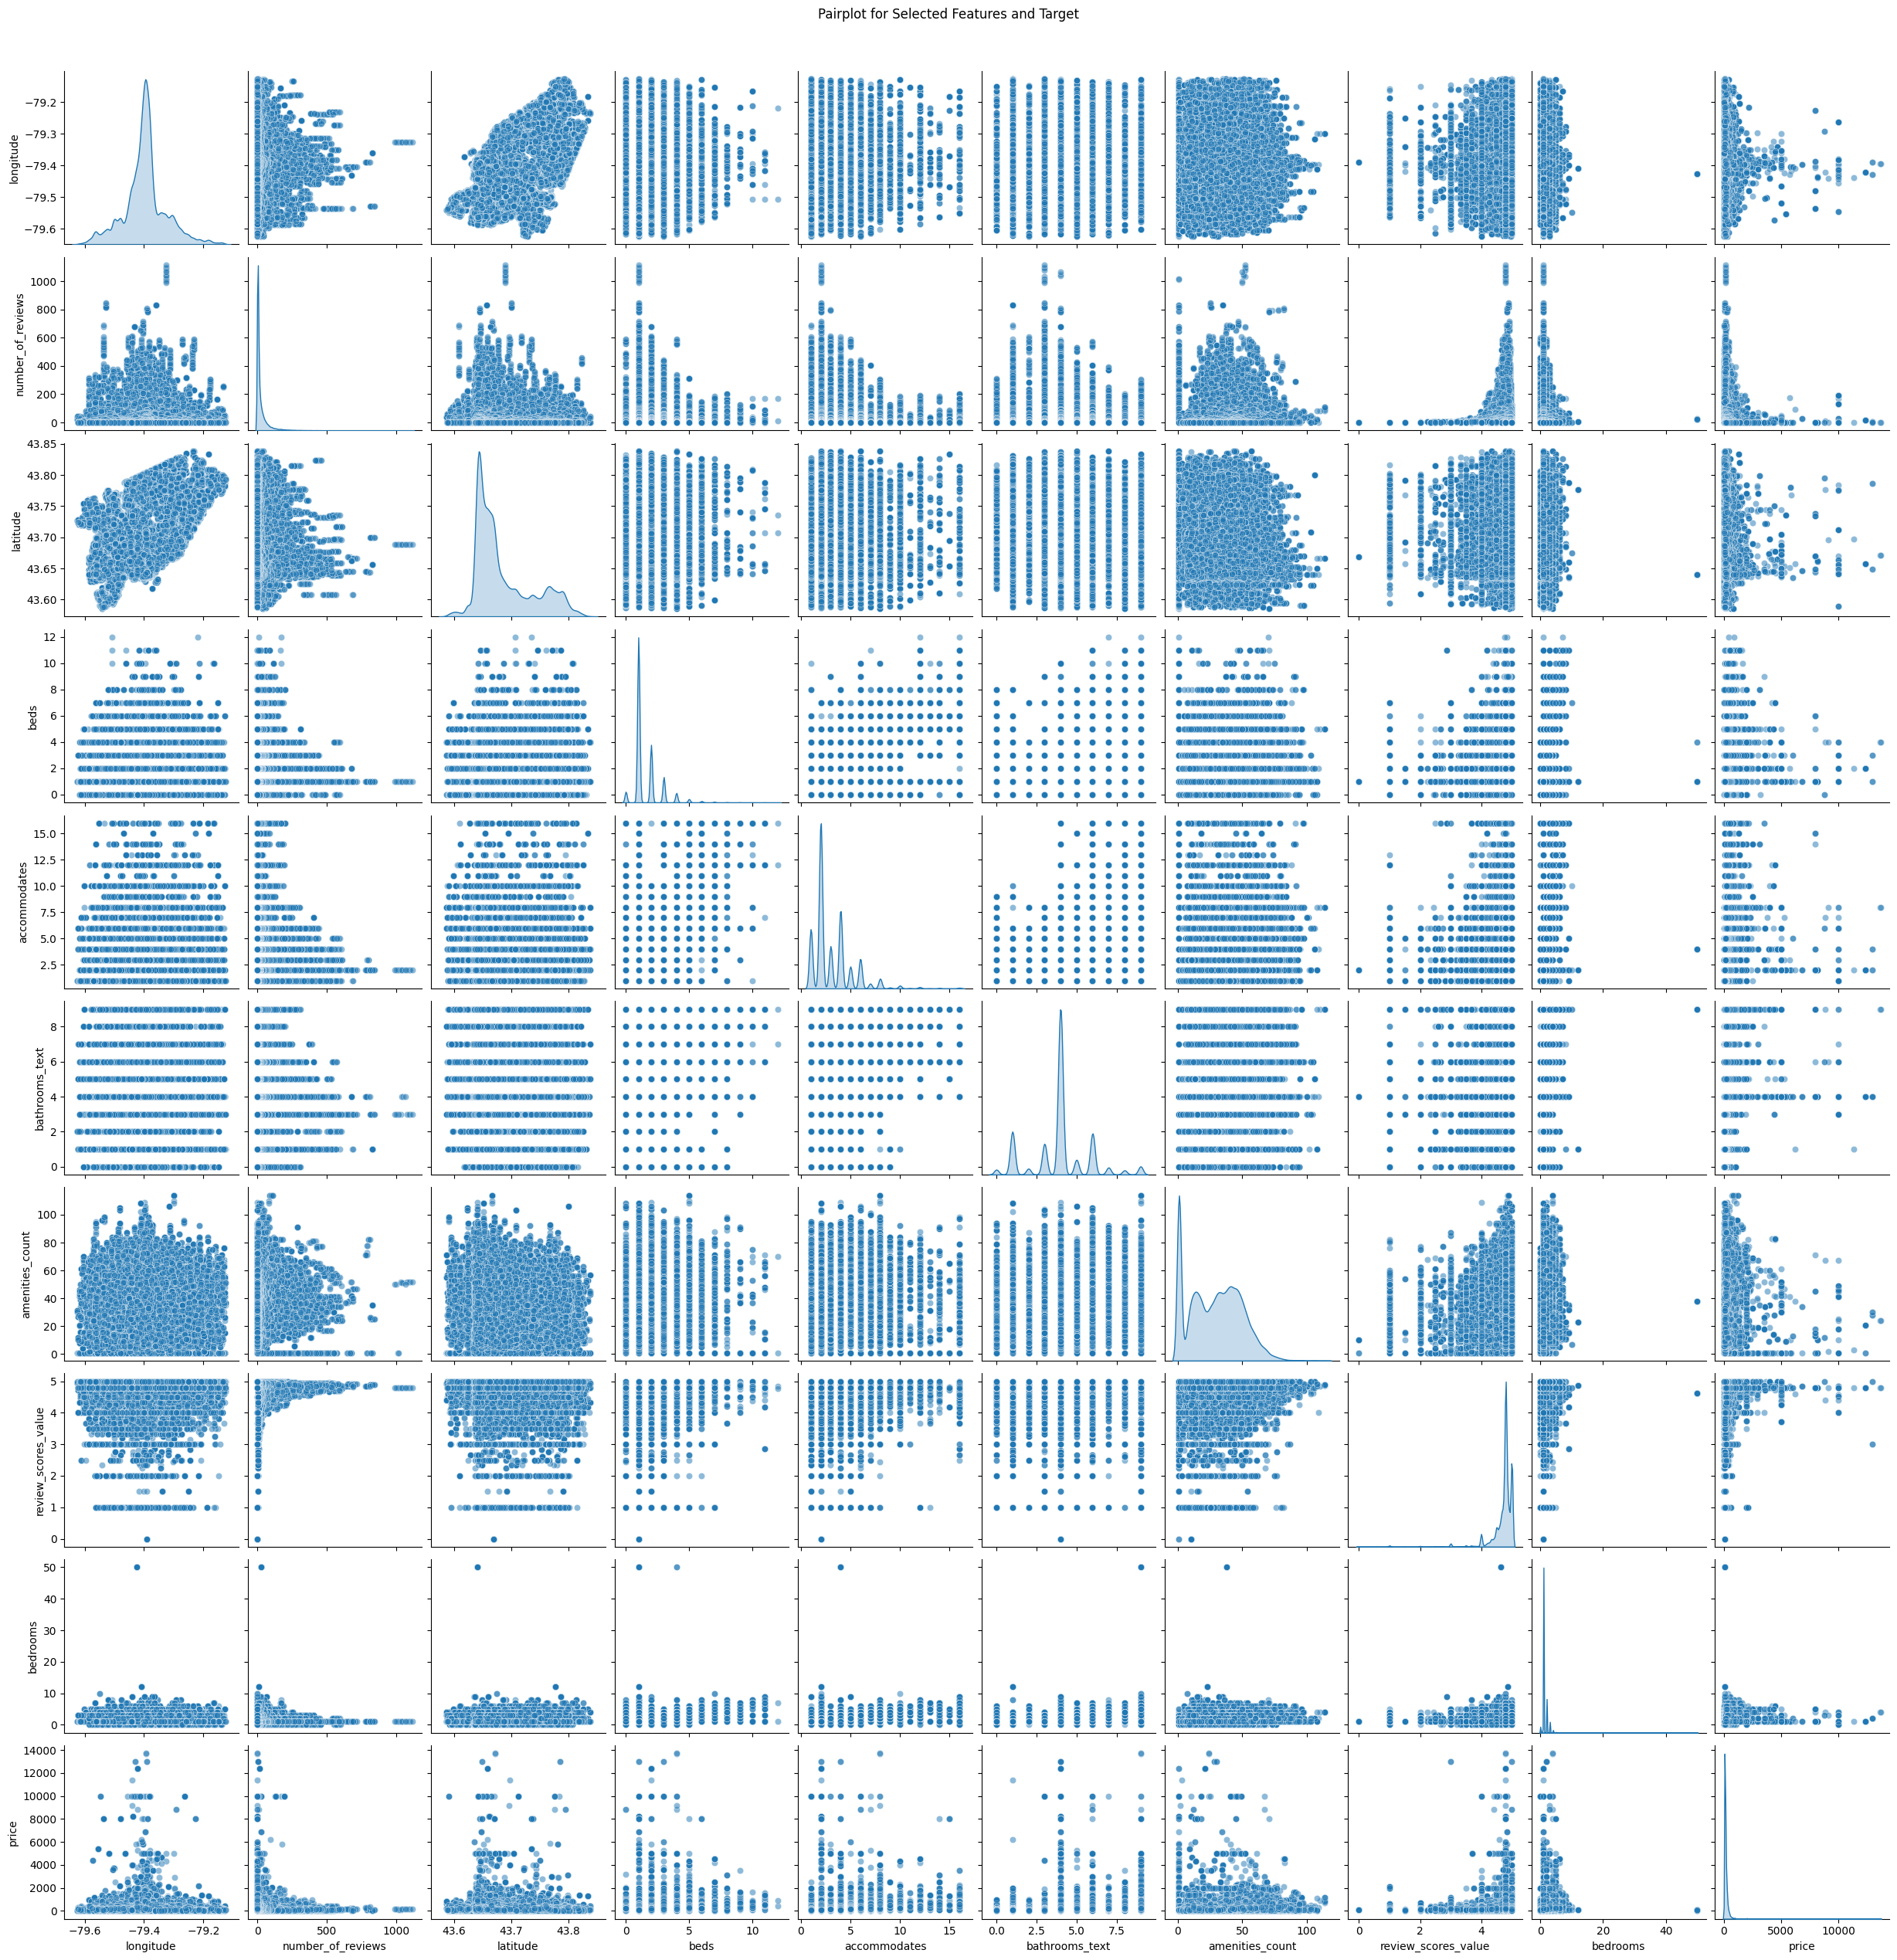

In [39]:
features = ['longitude', 'number_of_reviews', 'latitude', 'beds', 'accommodates', 
            'bathrooms_text', 'amenities_count', 'review_scores_value', 'bedrooms'] + \
           list(df_X_train.columns[df_X_train.columns.str.startswith('room_type_')]) + \
           list(df_X_train.columns[df_X_train.columns.str.startswith('property_type_')])
# Create pairplot for selected features
sns.pairplot(df_X_train[features + ['price']], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle("Pairplot for Selected Features and Target", y=1.02)
plt.show()


## Dimensionality Reduction with PCA to Visualize Class Separability

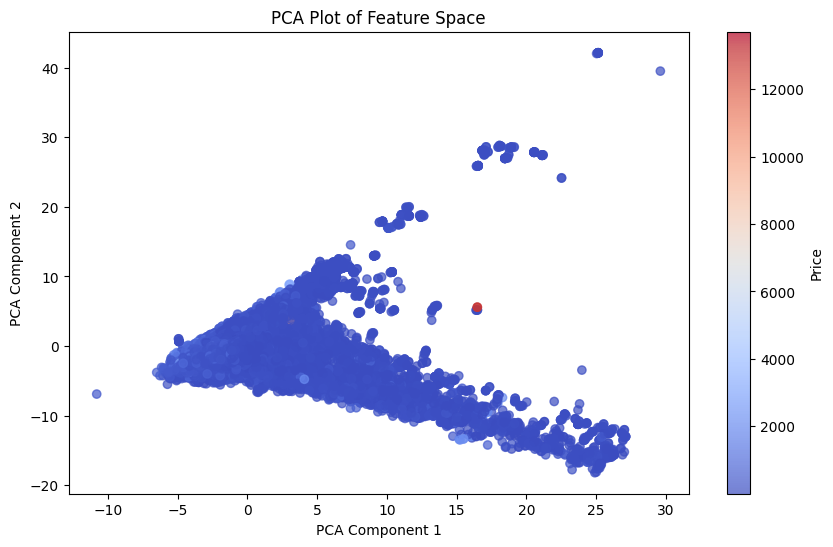

Explained variance ratio: [0.10855888 0.10172411]


In [44]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D or 3D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize PCA components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_X_train['price'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Price')
plt.title("PCA Plot of Feature Space")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Print explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

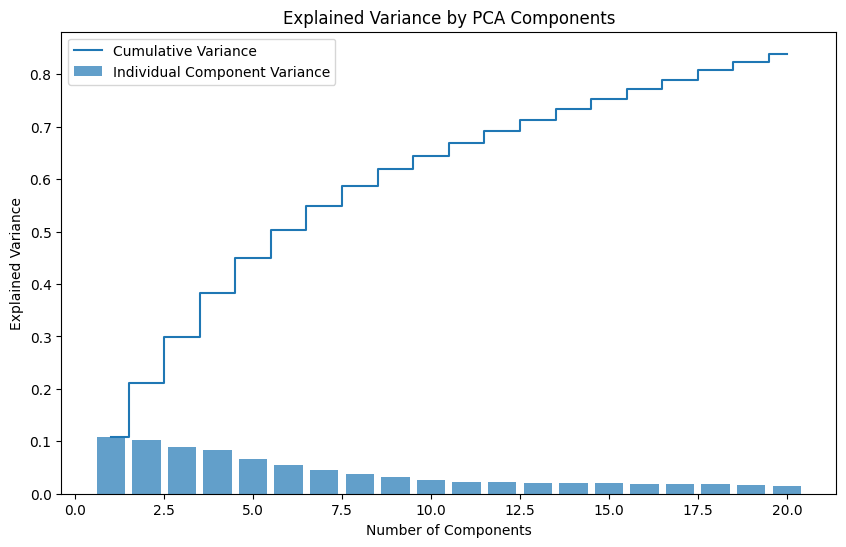

In [50]:

import numpy as np

# Apply PCA with more components (e.g., 10 or more)
pca = PCA(n_components=20)  
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Component Variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()




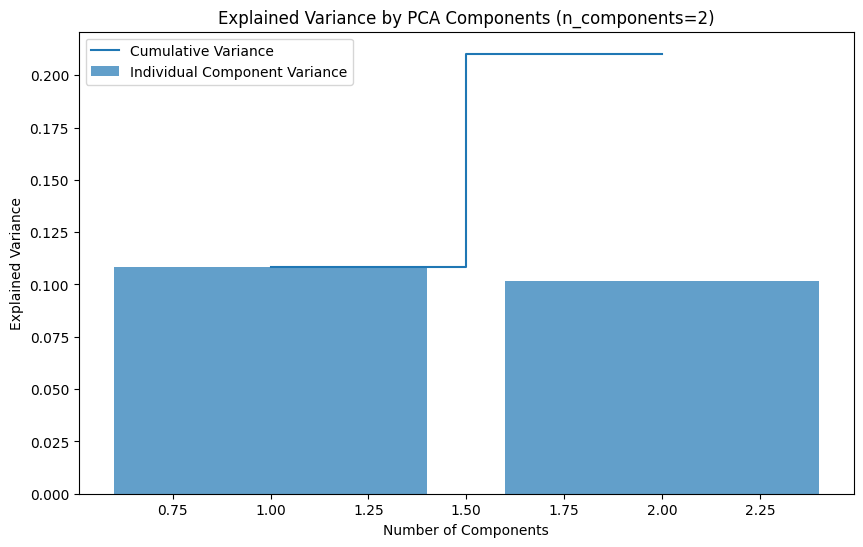

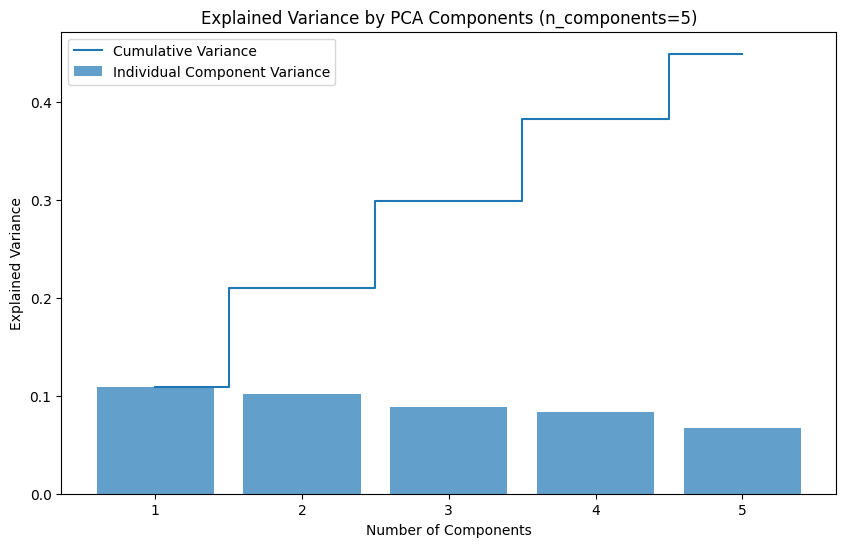

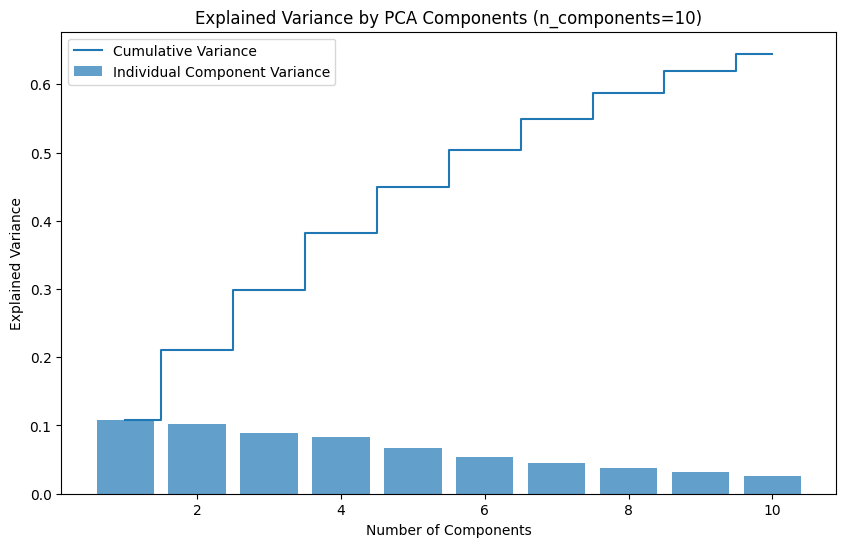

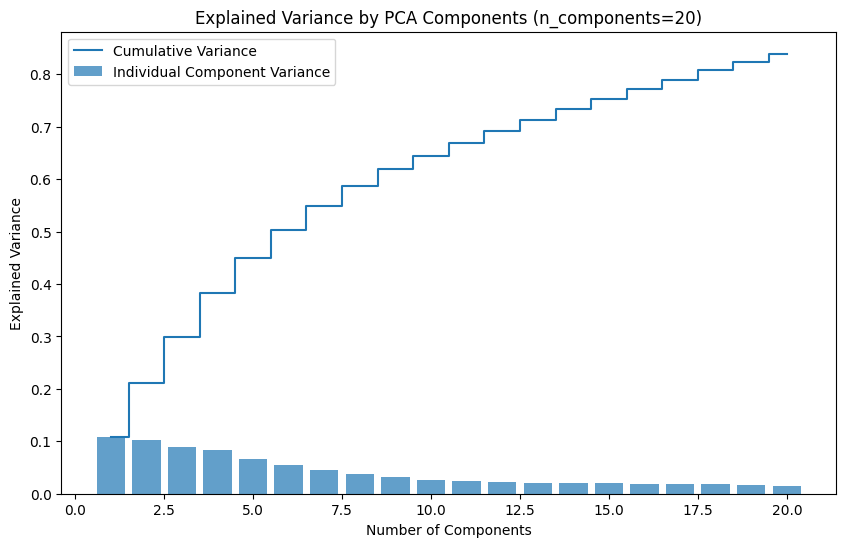

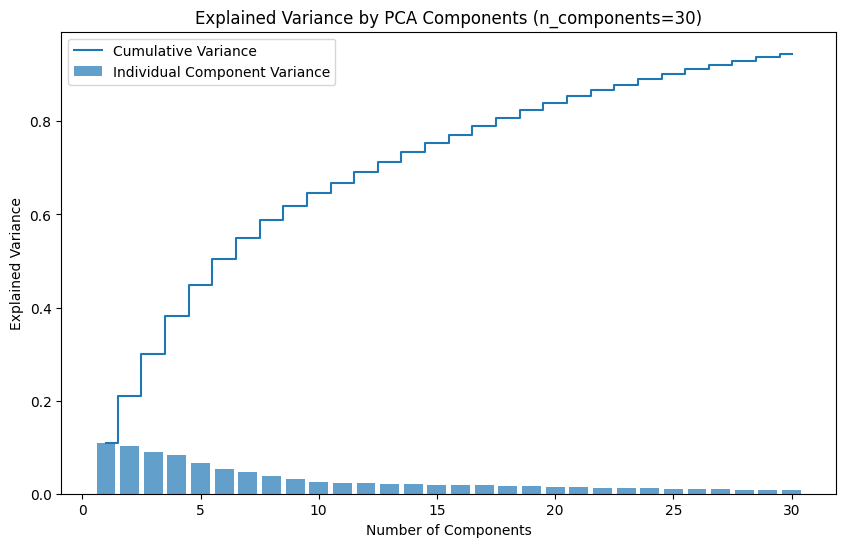

In [53]:

# Define the list of components to evaluate
components_list = [2, 5, 10, 20, 30]

# Loop through different numbers of PCA components
for n_components in components_list:
    # Apply PCA with dynamic number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Calculate the explained variance
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance by each component
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Component Variance')
    plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title(f'Explained Variance by PCA Components (n_components={n_components})')
    plt.legend(loc='best')
    plt.show()

    # Calculate cumulative variance for 90% and 95%
    cumulative_variance = np.cumsum(explained_variance)
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # First component where cumulative variance >= 90%
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # First component where cumulative variance >= 95%


### Feature Selection with Recursive Feature Elimination (RFE)

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Define the estimator and RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_scaled, df_X_train['price'])

# Get the selected features
selected_rfe_features = np.array(df_X_train.columns.drop('price'))[rfe.support_]
print("Selected features by RFE:", selected_rfe_features)


Selected features by RFE: ['accommodates' 'maximum_maximum_nights' 'maximum_nights_avg_ntm'
 'calculated_host_listings_count'
 'calculated_host_listings_count_entire_homes']


### Feature Selection and Data Preprocessing for Regression Analysis


In [30]:
# Feature Selection and Data Preprocessing for Regression Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_regression
import pandas as pd
# Step 3: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X_train.drop(columns=['price']))  # Drop target

# Step 4: Define the target
y =df_X_train['price']

# Step 5: Feature Selection using F-test
F_stat, p_values = f_regression(X_scaled, y)

# Display F-statistics and p-values
for i, feature in enumerate(df_X_train.columns.drop('price')):
    print(f"{feature}: F-statistic = {F_stat[i]}, p-value = {p_values[i]}")

source: F-statistic = 2747.8784789692913, p-value = 0.0
host_response_time: F-statistic = 177.61045355658155, p-value = 1.6638104426693868e-40
host_is_superhost: F-statistic = 111.6081295192939, p-value = 4.4098562995338965e-26
host_listings_count: F-statistic = 203.40214095758196, p-value = 3.941678410472171e-46
host_verifications: F-statistic = 104.93897952760278, p-value = 1.2738502726100756e-24
host_identity_verified: F-statistic = 211.99578896633366, p-value = 5.275439886849224e-48
neighbourhood_cleansed: F-statistic = 5004.829436135341, p-value = 0.0
latitude: F-statistic = 2629.1865929481623, p-value = 0.0
longitude: F-statistic = 3.612211590508182, p-value = 0.057357952974414726
property_type: F-statistic = 11156.867319027533, p-value = 0.0
room_type: F-statistic = 9190.37739703368, p-value = 0.0
accommodates: F-statistic = 21391.31715623161, p-value = 0.0
bathrooms: F-statistic = 12711.948590043105, p-value = 0.0
bathrooms_text: F-statistic = 16236.001956702165, p-value = 0.0


### Chi-Square Test


In [55]:
# Chi-Square Test
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Apply MinMax scaling for chi-square test (works for non-negative values)
scaler = MinMaxScaler()
X_scaled_chi2 = scaler.fit_transform(X)

# Apply chi2 test
chi2_stat, p_values_chi2 = chi2(X_scaled_chi2, y)

# Display results
for i, feature in enumerate(X.columns):
    print(f"{feature}: Chi-square = {chi2_stat[i]}, p-value = {p_values_chi2[i]}")


source: Chi-square = 39495.913134764945, p-value = 0.0
host_response_time: Chi-square = 765.4704518373126, p-value = 1.0
host_is_superhost: Chi-square = 11616.192156718886, p-value = 0.0
host_listings_count: Chi-square = 4333.359379329913, p-value = 0.0
host_verifications: Chi-square = 2412.9960908920825, p-value = 1.0679995185035661e-72
host_identity_verified: Chi-square = 1439.6396513431948, p-value = 0.0009546656598127128
neighbourhood_cleansed: Chi-square = 8224.943778550338, p-value = 0.0
latitude: Chi-square = 2951.851558113014, p-value = 5.528936819103596e-134
longitude: Chi-square = 153.72821228494757, p-value = 1.0
property_type: Chi-square = 15938.187347755675, p-value = 0.0
room_type: Chi-square = 6391.440520684098, p-value = 0.0
accommodates: Chi-square = 11578.507097774238, p-value = 0.0
bathrooms: Chi-square = 247.51633943882223, p-value = 1.0
bathrooms_text: Chi-square = 6571.51770035719, p-value = 0.0
bedrooms: Chi-square = 575.2594817606067, p-value = 1.0
beds: Chi-squ

### Feature Importance using Random Forest

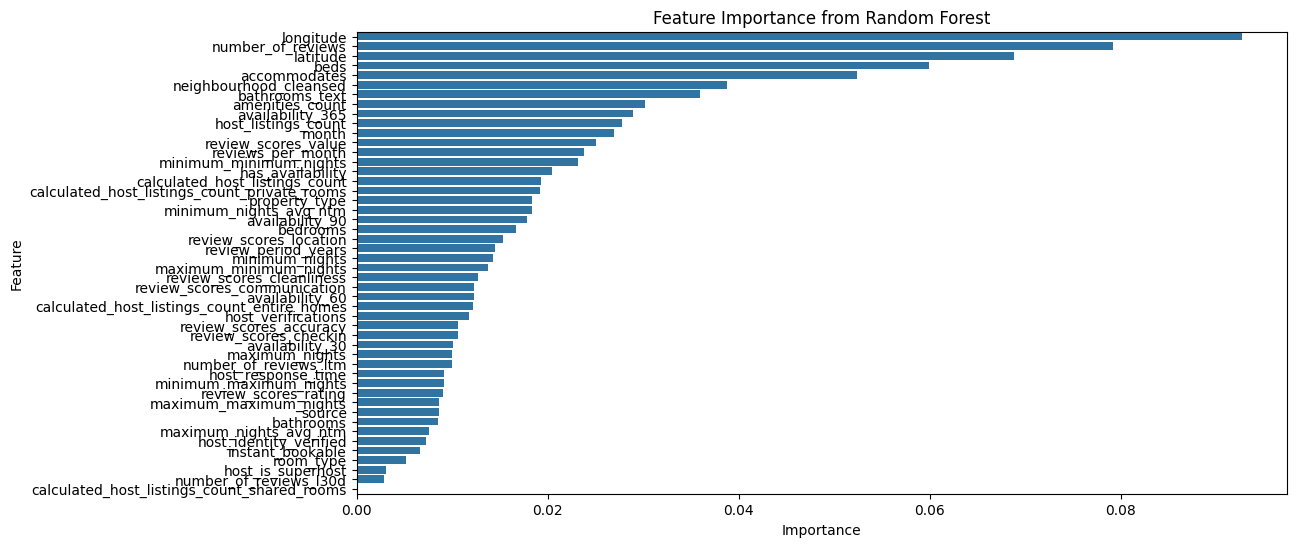

In [57]:
# Feature Importance using Random Forest

from sklearn.ensemble import RandomForestRegressor

# Define the target and features
X = df_X_train.drop(columns=['price'])  # Assuming 'Price' is the target variable
y = df_X_train['price']

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importance
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.show()

### visualize the target predictability

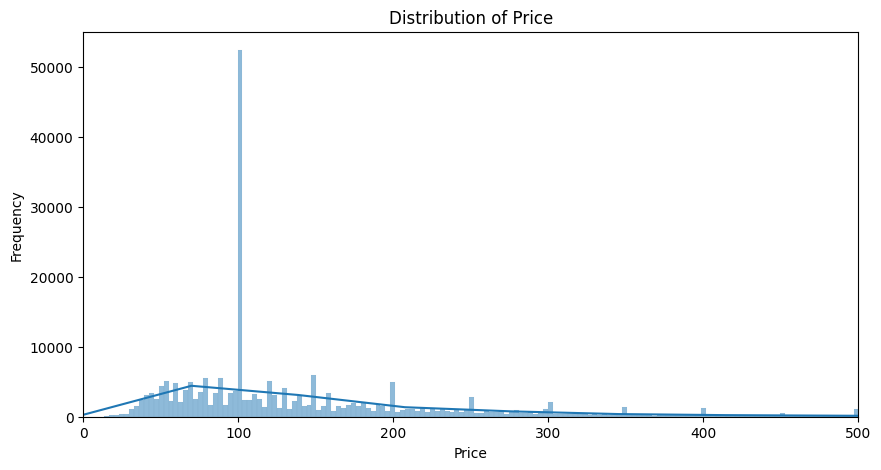

In [65]:
# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(df_X_train['price'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Set x-axis limits
plt.xlim(0, 500)  # Change x-axis limits to range from 0 to 2000

plt.show()

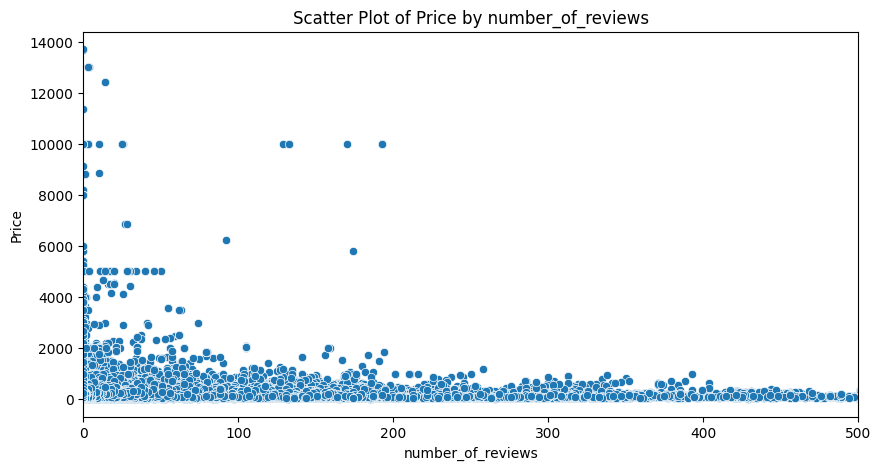

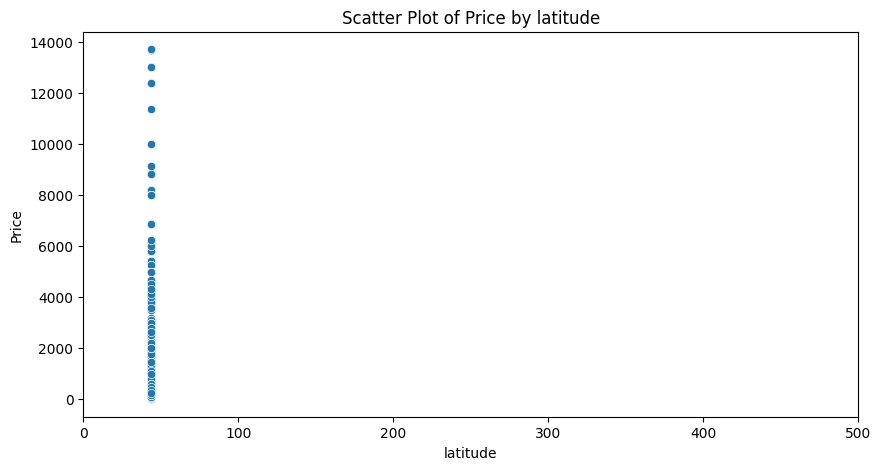

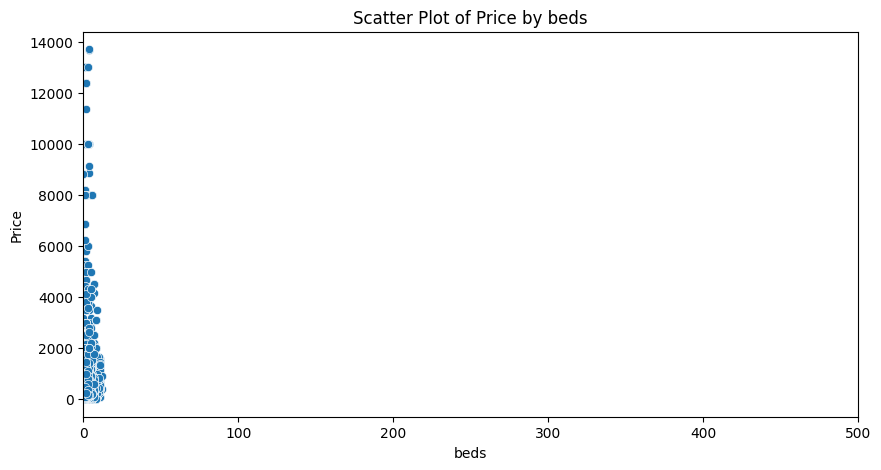

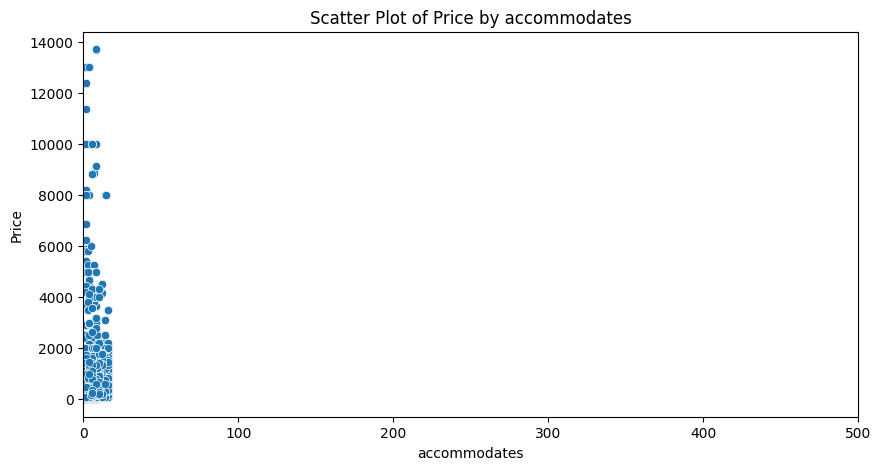

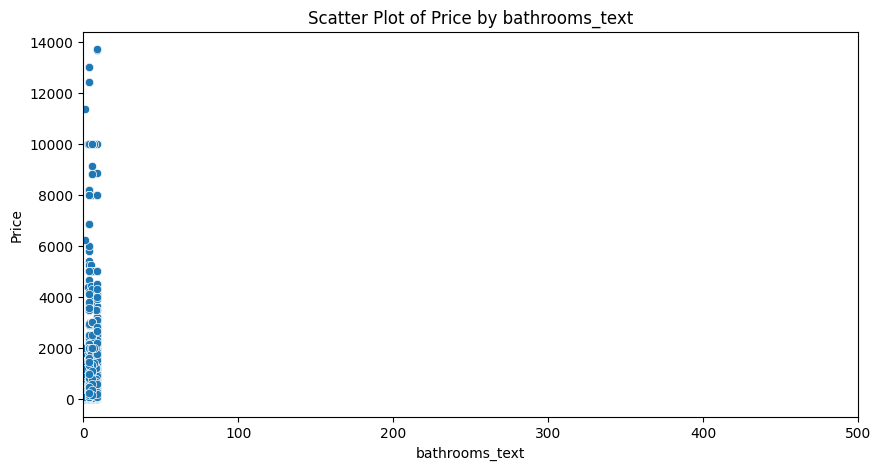

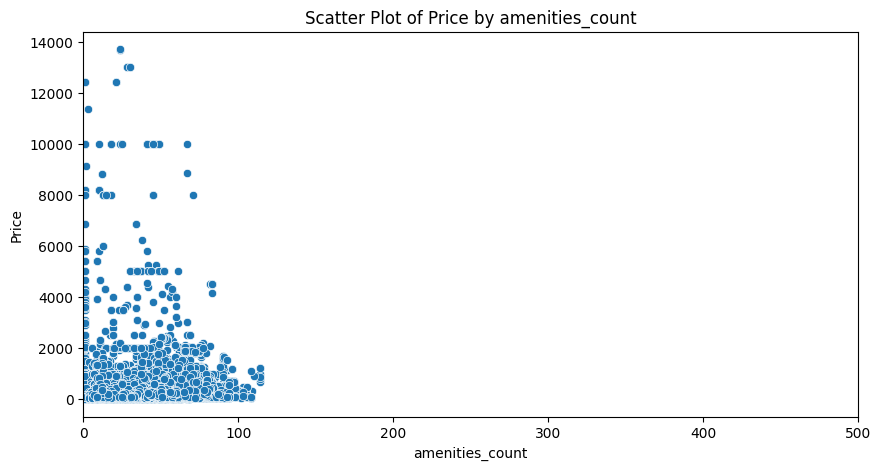

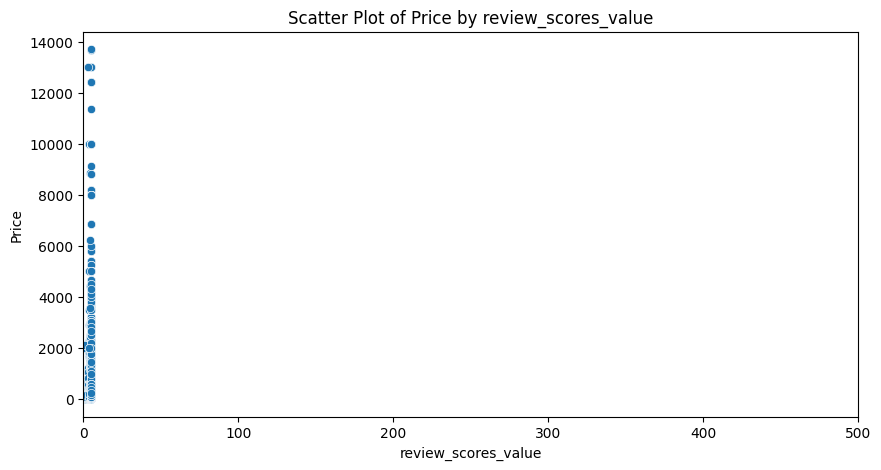

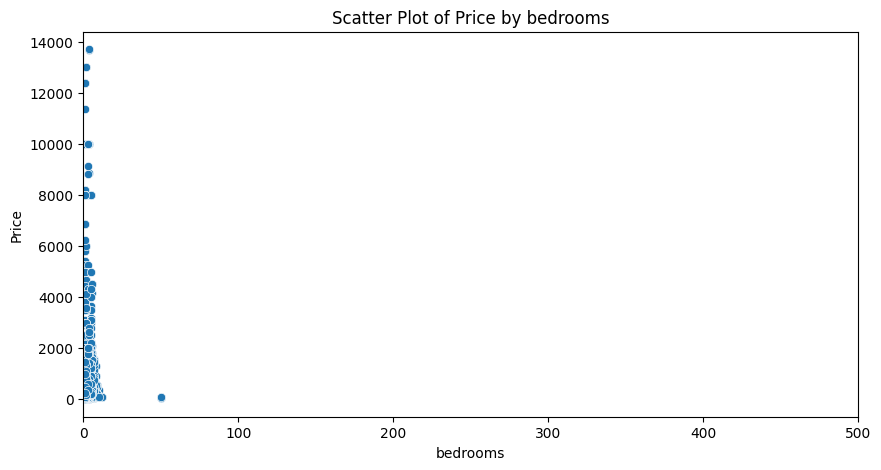

In [74]:
selected_feature = ['number_of_reviews', 'latitude', 'beds', 'accommodates', 
                    'bathrooms_text', 'amenities_count', 'review_scores_value', 'bedrooms'] + \
                   list(df_X_train.columns[df_X_train.columns.str.startswith('room_type_')]) + \
                   list(df_X_train.columns[df_X_train.columns.str.startswith('property_type_')])

# Loop through each feature and create scatter plots
for feature in selected_feature:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df_X_train[feature], y=df_X_train['price'])
    plt.title(f'Scatter Plot of Price by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.xlim(0, 500)  # Set x-axis limits as needed
    plt.show()


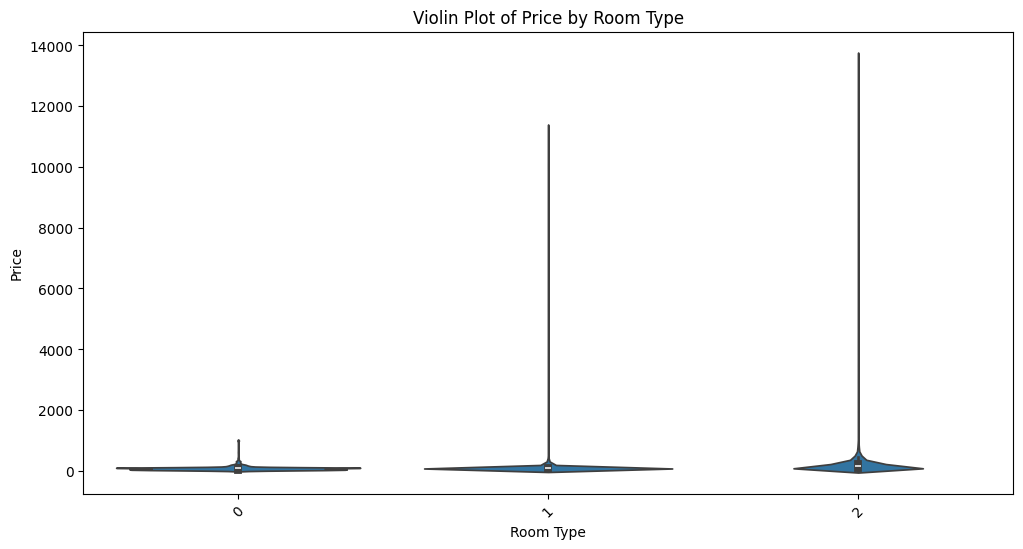

In [84]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='room_type', y='price', data=df_X_train)
plt.title('Violin Plot of Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

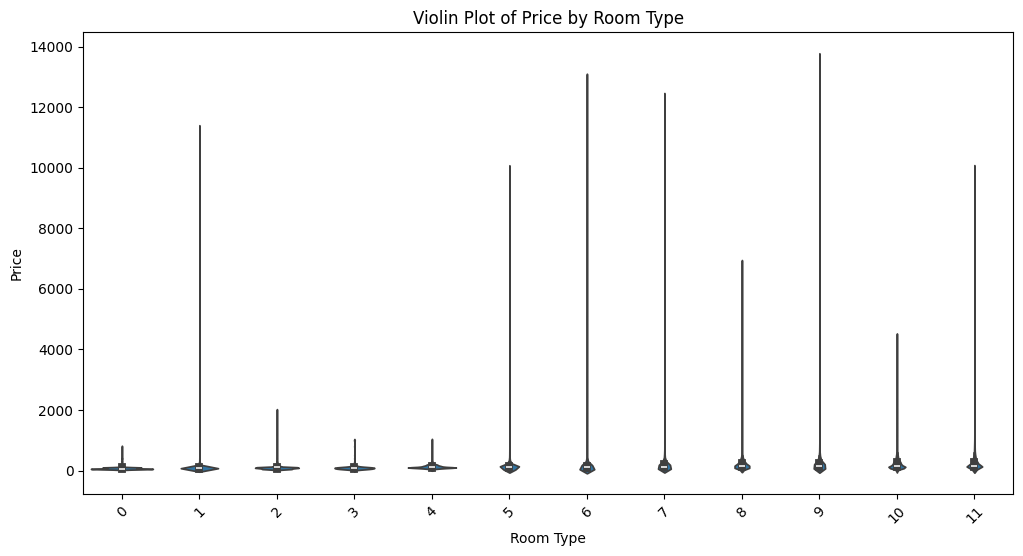

In [85]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='property_type', y='price', data=df_X_train)
plt.title('Violin Plot of Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()